# Creación gráficos de artículo

In [1]:
!pip install matplotlib==3.2.2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex
from matplotlib import cm, ticker
import os
from google.colab import files

# Carga de archivo de almacenamiento de gráficos
funciones1 = __import__('850_funcion1')

## Lectura de modelos

In [3]:
! unzip -q model_001.zip -d model_001/
! unzip -q model_002.zip -d model_002/

In [4]:
model_001 = tf.keras.models.load_model('model_001')
model_002 = tf.keras.models.load_model('model_002')

In [5]:
model_002.predict([[2000, 12, 2, 100]])

array([[0.6524262 , 0.08966365]], dtype=float32)

## Simulaciones

In [6]:
def expand_grid(x, y, xval = 'x', yval = 'y'):
  """
  Función de expansión de malla
  """
  xG, yG = np.meshgrid(x, y) # Crear malla
  xG = xG.flatten() # Hacer malla 1D
  yG = yG.flatten() # Igual
  return pd.DataFrame({xval:xG, yval:yG})

def simularANN(variables, modelo, 
               orden = ['DD', 'II', 'Tinf', 'CLCR', 'MIC']):
  """
  Función de simulación de datos de acuerdo a una especificación de malla
  """
  dictArray  = [(i,k) for (i,k) in variables.items() if type(k) == np.ndarray]
  floatArray = [(i,k) for (i,k) in variables.items() if type(k) != np.ndarray]

  if len(dictArray) > 2:
    return
  
  sampleDF = expand_grid(dictArray[0][1], 
                        dictArray[1][1], 
                        xval = dictArray[0][0], 
                        yval = dictArray[1][0])

  for i in range(len(floatArray)):
    var, val = floatArray[i];
    sampleDF[var] = val

  sampleDF = sampleDF[orden]
  resultados = {'x': dictArray[0], 'y': dictArray[1], 'z': modelo.predict(sampleDF)}
  return resultados

In [7]:
objetoDict = {
  'MIC': 0,
  'DD': np.linspace(1500, 3000, 200),
  'II': 12,
  'Tinf': 2,
  'CLCR': np.linspace(90, 150, 200)
}

ANN_1 = simularANN(objetoDict, model_001)

In [8]:
objetoDict = {
  'DD': np.linspace(1500, 3000, 200),
  'II': 12,
  'Tinf': 2,
  'CLCR': np.linspace(90, 150, 200)
}

ANN_2 = simularANN(objetoDict, model_002, orden = ['DD', 'II', 'Tinf', 'CLCR'])

## Creación de gráficos

In [9]:
def crearGraficoMplt(data, x='x', y='y', z='z', ax = None, levels = [0.85], normalize_range=[0,1], colour_map = 'Spectral', n_levels=30, selected_output = 0):
  """
  Función de creación de mapa de contornos
  """
  if ax is None:
    ax = plt.gca()
  
  # Largo de dataframe (primera dimensión)
  shape1 = np.shape(data[z])
  
  n = np.sqrt(shape1[0]).astype(int)

  if shape1[1] == 1:
    grid_data = data[z].reshape((n,n))
  else:
    grid_data = data[z][:, selected_output].reshape((n,n))


  # Límites de normalización de escala de color
  normalize1 = Normalize(vmin = normalize_range[0], vmax = normalize_range[1], clip=True)
  # Crear malla bidimensional con datos
  x1, y1 = np.meshgrid(data[x][1], data[y][1])
  # Contornos
  main = ax.contourf(x1, y1, grid_data, n_levels, cmap=colour_map, norm = normalize1)
  csil = ax.contour(x1, y1, grid_data, levels=levels, linewidths=[1], linestyles=('--'), colors='black')
  ax.clabel(csil, inline=True, fontsize=10, fmt='%1.2f')

  return(ax)

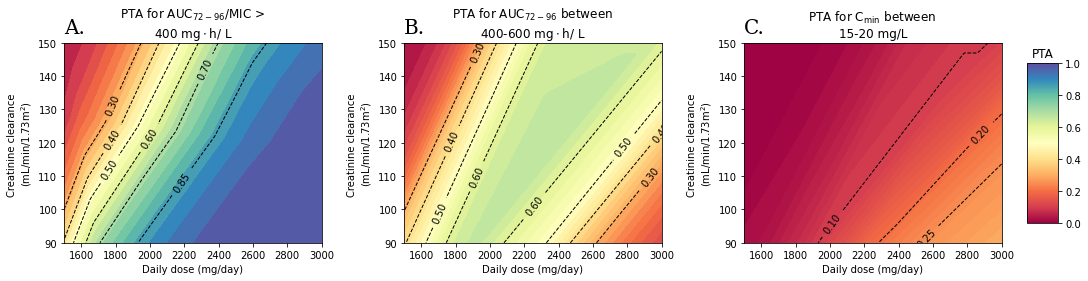

<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax = plt.subplots(1,3, figsize=(15, 3.8), constrained_layout=True,)

# Gráfico de PTA 1: AUC/MIC > 400 mg*h/L
crearGraficoMplt(ANN_1, ax = ax[0], levels = [0.3,0.4,0.5,0.6,0.7,0.85]);
ax[0].set_title('PTA for $\mathrm{AUC}_{72-96}$/MIC > \n400 $\mathrm{mg\cdot h/~L}$')
ax[0].set_title('A.', fontfamily='serif', loc='left', fontsize=20, fontdict = {'verticalalignment':'bottom'})

# Gráfico de PTA 2: AUC entre 400-600 mg*h/L
crearGraficoMplt(ANN_2, ax = ax[1], selected_output=0, levels = [0.3,0.4,0.5,0.6]);
ax[1].set_title('PTA for $\mathrm{AUC}_{72-96}$ between \n400-600 $\mathrm{mg\cdot h/~L}$')
ax[1].set_title('B.', fontfamily='serif', loc='left', fontsize=20, fontdict = {'verticalalignment':'bottom'})

# Gráfico de PTA 3: C_min entre 15-20 mg/L
crearGraficoMplt(ANN_2, ax = ax[2], selected_output=1, levels = [0.1, 0.2, 0.25]);
ax[2].set_title('PTA for $\mathrm{C_{min}}$ between \n15-20 mg/L')
ax[2].set_title('C.', fontfamily='serif', loc='left', fontsize=20, fontdict = {'verticalalignment':'bottom'})

[i.set_xlabel('Daily dose (mg/day)') for i in ax];
[i.set_ylabel('Creatinine clearance \n(mL/min/1.73$\mathrm{m}^2$)') for i in ax];

cbar1 = plt.colorbar(cm.ScalarMappable(cmap='Spectral'), ax = ax[2], shrink=0.8);
cbar1.ax.set_title('PTA');
plt.show();
funciones1.guardarMatplotlib(plt.gcf(), '210_superficiePTA_articulo', path=os.path.join('.')); #bbox_inches='tight'

## Unificación de gráficos de Shap Values

In [11]:
!pip install shap
import shap

     |████████████████████████████████| 371 kB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509237 sha256=d1d75b7e5893af758fc4f5060bca6672d961196433f33104513dabb38fe6285f
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [12]:
# def extraerDatos1(ax):
#   X = []   
#   # for lines in plt.gca().get_lines():
#   for i, collections in enumerate(ax.collections):
#     # print(lines)
#     # print(lines.get_offsets())
#     if i%2!=0: 
#       # print(np.shape(lines.get_offsets()))
#       for j, ((x, y), c) in enumerate(zip(collections.get_offsets(), collections.get_ec())):
#         # print((x,y,c))
#         X.append({'id': j, 'item':i, 'x':x, 'y':y, 'c': [round(j,2) if j < 1 else 1 for j in c]})
#   X_df = pd.DataFrame(X)
#   return(X_df)
# ax1 = load(open(os.path.join('/content/018_shapValuesPTA_AUCMIC'), 'rb'))
# X_df_0 = extraerDatos1(ax1.axes[0])
# ax2 = load(open(os.path.join('/content/110b_shapValuesPTA_AUCMIC_0'), 'rb'))
# X_df_1 = extraerDatos1(ax2.axes)

In [13]:
X_train_1 = pd.read_csv('001_Xtrain.csv')
X_train_2 = pd.read_csv('100_Xtrain.csv')
Shape_1 = np.load('001_shape_values.npy')
Shape_2 = np.load('100_shape_values.npy')

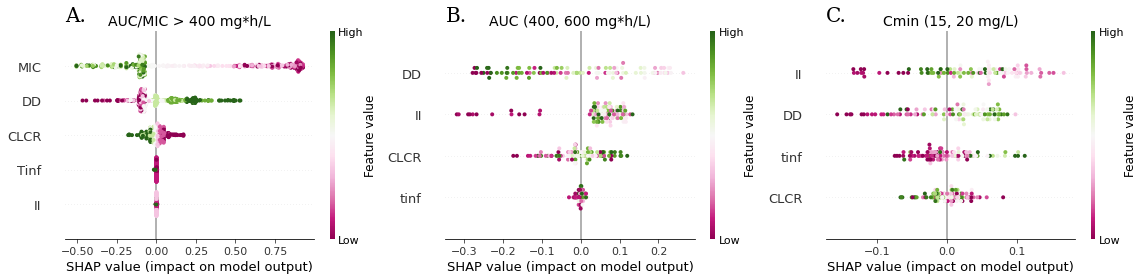

In [25]:
list_titulos = ['AUC (400, 600 mg*h/L)', 'Cmin (15, 20 mg/L)']
list_tags = ['B.', 'C.']

fig = plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
shap.summary_plot(shap_values = Shape_1, features = X_train_1, 
                    show=False, plot_size=None, sort=True, cmap='PiYG')
plt.gca().set_title("AUC/MIC > 400 mg*h/L", fontdict={"size": 14})
plt.gca().set_title('A.', fontfamily='serif', loc='left', fontsize=20, fontdict = {'verticalalignment':'bottom'})

for i in range(2):
  plt.subplot(1,3,i+2)
  shap.summary_plot(shap_values = Shape_2[i], features = X_train_2, 
                    show=False, plot_size=None, sort=True, cmap="PiYG")
  ax = plt.gca()
  # ax.set_xlabel('Valor SHAP (impacto en indicador PK/PD)')
  ax.set_title(list_titulos[i], fontdict={"size": 14})
  ax.set_title(list_tags[i], fontfamily='serif', loc='left', fontsize=20, fontdict = {'verticalalignment':'bottom'})
fig.set_tight_layout(True)
# plt.show()
plt.savefig('211_valoresShap1.pdf')

In [20]:
# j%matplotlib inline
# color_map = "PiYG"

# fig, ax = plt.subplots(1,3, figsize = (13, 4), constrained_layout=True,)

# ax[0].scatter(X_df_0['x'], X_df_0['y'], c = X_df_0['x'], s=5)
# ax[0].set_yticks([0,1,2,3,4])
# ax[0].set_yticklabels(['$\mathrm{T_{inf}}$', 'II', 'ClCr', 'DD', 'MIC'])
# ax[0].set_title('PTA for $\mathrm{AUC}_{72-96}$/MIC > \n400 $\mathrm{mg\cdot h/~L}$')
# ax[0].set_title('A.', fontfamily='serif', loc='left', fontsize=20, fontdict = {'verticalalignment':'bottom'})


# ax[1].scatter(X_df_1['x'], X_df_1['y'], c = X_df_1['x'], s=5)
# ax[1].set_yticks([0,1,2,3])
# ax[1].set_yticklabels(['$\mathrm{T_{inf}}$', 'ClCr', 'II', 'DD'])
# ax[1].set_title('PTA for $\mathrm{AUC}_{72-96}$ between \n400-600 $\mathrm{mg\cdot h/~L}$')
# ax[1].set_title('B.', fontfamily='serif', loc='left', fontsize=20, fontdict = {'verticalalignment':'bottom'})


# ax[2].scatter(X_df_2['x'], X_df_2['y'], c = X_df_2['x'], s=5)
# ax[2].set_yticks([0,1,2,3])
# ax[2].set_yticklabels(['ClCr', '$\mathrm{T_{inf}}$', 'DD', 'II'])
# ax[2].set_title('PTA for $\mathrm{C_{min}}$ between \n15-20 mg/L')
# ax[2].set_title('C.', fontfamily='serif', loc='left', fontsize=20, fontdict = {'verticalalignment':'bottom'})

# # [i.set_xlim([-0.6, 1.0]) for i in ax]
# [i.set_xlabel('SHAP value (impact on model output)') for i in ax]

# # cbar1 = plt.colorbar(cm.ScalarMappable(cmap=color_map), ax = ax[2], shrink=0.8, 
# #                      ticks=[0, 1]);
# # cbar1.ax.set_yticklabels(['Bajo', 'Alto'])

# fig.show()

In [21]:
files.download('210_superficiePTA_articulo.pdf')
files.download('210_superficiePTA_articulo')
files.download('211_valoresShap1.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>